In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import IntegerComparator, GroverOperator
from collections.abc import Callable
import numpy as np 

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
def comparator_oracle(qc: QuantumCircuit, n, value):
    # qc = QuantumCircuit(n * 2 + 1)
    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()
    qc.append(ic, qc.qubits[:-1])
    qc.cx(n, n*2)
    qc.append(ici, qc.qubits[:-1])
    return qc

In [25]:
def grover(n, value):
    iter = int(np.sqrt(n))
    n = int(np.ceil(np.log2(n)))

    qc = QuantumCircuit(n * 2 + 1, n)
    qc.x(n * 2)
    qc.h(list(range(n)) + [n * 2])

    qc.barrier()

    for i in range(iter):
        comparator_oracle(qc, n, value)
        qc.append(diffuser(n), qc.qubits[0:n])

        qc.barrier()

    qc.measure(qc.qubits[0:n], qc.clbits[:])
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

In [28]:
def durrHoyer(nums, iter = None):
    n = len(nums)
    thres = np.random.randint(n)
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log(n) ** 2)
    gmin = thres
    print('running iter:', iter)
    for i in range(iter):
        nmin = grover(n, thres)
        if nmin < gmin:
            gmin = nmin
            thres = gmin
    return gmin

In [33]:
nums = np.arange(20)
np.random.shuffle(nums)
print(nums)
durrHoyer(nums)

[19  4 14 18 17 11 15 13  5 12 16  2  7  0  1 10  9  3  8  6]
running iter: 113


0

{'0101': 90, '0110': 94, '1111': 97, '1001': 81, '1010': 87, '0111': 98, '1100': 87, '1101': 75, '1000': 119, '1110': 70, '1011': 102, '0011': 4, '0001': 9, '0100': 8, '0000': 1, '0010': 2}


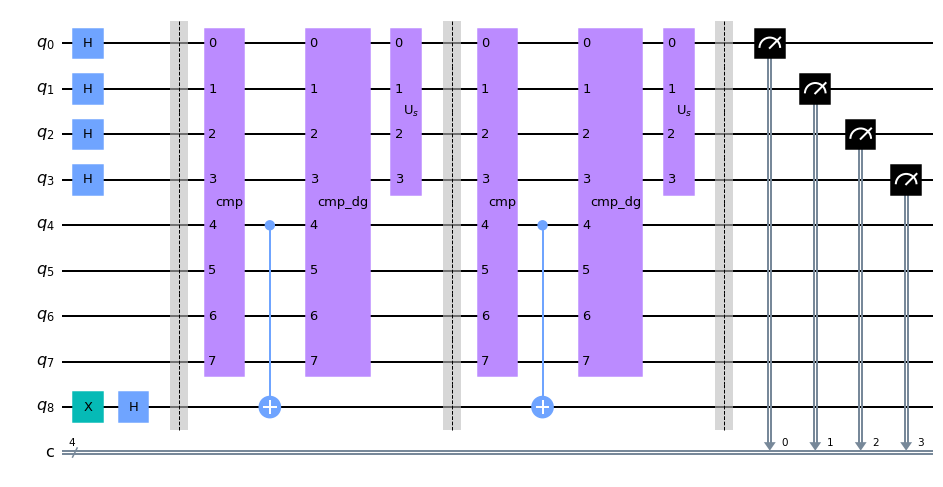

In [155]:

n = 4
value = 5
iter = int(np.floor(np.sqrt(n)))

qc = QuantumCircuit(n * 2 + 1, n)
qc.x(n * 2)
qc.h(list(range(n)) + [n * 2])

qc.barrier()

for i in range(iter):
    comparator_oracle(qc, n, value)
    qc.append(diffuser(4), qc.qubits[0:n])

    qc.barrier()

qc.measure(qc.qubits[0:n], qc.clbits[:])
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
print(counts)
qc.draw('mpl')

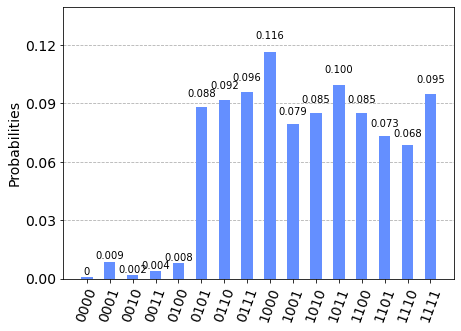

In [156]:
plot_histogram(counts)

In [65]:
ic.value

6

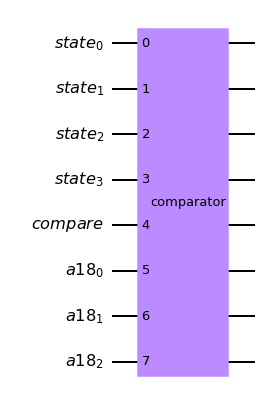

In [29]:
ic.draw('mpl')

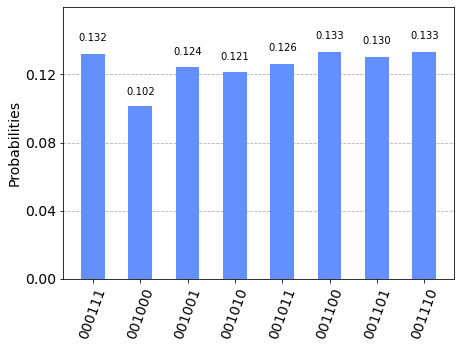